### Building word2Vec model out of StackOverflow tags submitted with questions

This is a first attempt to build the word2Vec model based on StackOverflow tags using Gensim library.
Tags for a question are effectively considered as a sentence. As a result, the word2Vec model will have vectors for all (almost) tags, and we can run similarity tasks (and other ones such as clustering or 2-D plotting). 

word2Vec is probably an overkill for such problem. Most of the "sentences" are quite short. Also, probably buidling a co-occurence matrix already gives lots of insights. However, having word2Vec vectors may be interesting for some tasks, and it is definitely fun to play with this model.

by DataQubit, June 2019

In [1]:
import numpy as np
import pandas as pd
import bq_helper
from bq_helper import BigQueryHelper
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
from IPython.display import HTML

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [41]:
%%bash
#pip install adjustText

In [42]:
from adjustText import adjust_text

In [2]:
%%bash
pip install MulticoreTSNE

  Stored in directory: /tmp/.cache/pip/wheels/27/59/53/3b52ee63add3692254c30d687fa4dff4d128d0557861fb028e
Successfully built MulticoreTSNE


You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# https://github.com/DmitryUlyanov/Multicore-TSNE
# pip install MulticoreTSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

In [3]:
def create_download_link(filename, title = "Download file"):
    """ generates a download line for the file"""
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [ ]:
stackOverflow = bq_helper.BigQueryHelper(active_project="bigquery-public-data",
                                   dataset_name="stackoverflow")

In [ ]:

# SQL query to extract tags
query_tags_count_dist = """
WITH tags_counts AS
    (SELECT ARRAY_LENGTH(SPLIT(tags, '|')) AS tag_count
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`)
SELECT tag_count, COUNT(1) AS tag_count_freq
FROM tags_counts
GROUP BY tag_count
ORDER BY tag_count;
""" 

In [ ]:
df_tags_cnt = stackOverflow.query_to_pandas_safe(query_tags_count_dist, max_gb_scanned=3.)

In [ ]:
df_tags_cnt.set_index('tag_count').plot(kind='bar', logy=True, figsize=(15, 5), title='Distribution of tag counts per question')

### Training Word2Vec model with Gensim

In [ ]:
# SQL query to extract tags
query_tags = """
SELECT SPLIT(tags, '|') AS tag_docs
FROM 
    `bigquery-public-data.stackoverflow.posts_questions`
WHERE ARRAY_LENGTH(SPLIT(tags, '|')) > 1
;
""" 

In [ ]:
df_tags = stackOverflow.query_to_pandas_safe(query_tags, max_gb_scanned=3.)

In [ ]:
len(df_tags)

In [ ]:
df_tags.head()

### Subsampling
Probability of including frequent words. As an example, a frequent tag 'python'.

In [ ]:
f = df_tags.tag_docs.apply(lambda x: 'python' in x).mean()

In [ ]:
t = 1.e-3
p = (f - t) / f - np.sqrt(t / f)
print(p)

### Initial parameters for word2Vec model:

In [ ]:
num_features = 200
min_word_count = 10
num_workers = 4
window_size = 5
subsampling = 1e-3

In [ ]:
model = Word2Vec(workers=num_workers,
                 size=num_features,
                 min_count=min_word_count,
                 window=window_size,
                 sample=subsampling)

#### Creating vocabulary

In [ ]:
model.build_vocab(df_tags.tag_docs)

In [ ]:
len(model.wv.vocab), model.wv.vectors.shape

#### Train the model

In [ ]:
model.train(df_tags.tag_docs, total_examples=model.corpus_count, epochs=model.epochs)

#### Save the model

In [ ]:
model.save("word2vec_tag_model_Jun13")

In [ ]:
ls -lth

In [ ]:
create_download_link('word2vec_tag_model_Jun13')

In [ ]:
model.similarity('python', 'algorithm')

In [ ]:
model.wv.most_similar(['python', 'pandas'], negative=['r'])

In [ ]:
model.wv.most_similar(['python'])

In [ ]:
model.wv.doesnt_match(list("browser google-chrome firefox html javascript machine-learning".split()))

In [ ]:
model.wv.similarity('python', 'java')

#### Other Experiments:

1. Using t-SNE (or PCA) to plot a number of most popular tags on a 2-D scatter plot.
2. Find interesting vector combinations.

In [ ]:
ls -lth ../input/stackoverflow/

### Loading model from the file

In [ ]:
ls -lth ../input/stackoverflow/

In [4]:
model = Word2Vec.load("../input/stackoverflow/word2vec_tag_model_jun13/word2vec_tag_model_Jun13")

In [5]:
df_tsne = pd.read_csv('../input/stackoverflow/tSNE_embed_vectors_word2vec_tag_model_Jun13.csv', index_col=[0])

In [6]:
df_tsne['vocab'] = model.wv.index2entity

In [ ]:
type(model.wv.vocab)

In [ ]:
df_tsne['word_count'] = [model.wv.vocab[item].count for item in df_tsne.vocab]

In [ ]:
df_tsne.head()

In [ ]:
#5 * np.log10(df_tsne.word_count)

In [ ]:
model.wv.index2word[0]

#### Using t-SNE to plot in 2-D

In [ ]:
X_emb = TSNE(n_components=2).fit_transform(model.wv.vectors)

In [ ]:
df_tsne300 = pd.DataFrame(TSNE(n_components=2).fit_transform(model.wv.vectors[:300]),
                         columns=['d1', 'd2'])

In [ ]:
df_pca300 = pd.DataFrame(PCA(n_components=2).fit_transform(model.wv.vectors[:300]),
                         columns=['d1', 'd2'])

In [ ]:
df_pca300['vocab'] = model.wv.index2entity[:300]

In [ ]:
df_tsne300['vocab'] = model.wv.index2entity[:300]

In [ ]:
df_tsne300.head()

In [ ]:
model.wv.vocab['javascript'].count

In [ ]:
#pd.DataFrame(X_emb, columns=['d1', 'd2']).plot(kind='scatter', x='d1', y='d2', alpha=0.2, figsize=(10, 10))

In [ ]:
#df_tsne.vocab.isin(df_tsne.vocab.iloc[0:100]).astype('int')

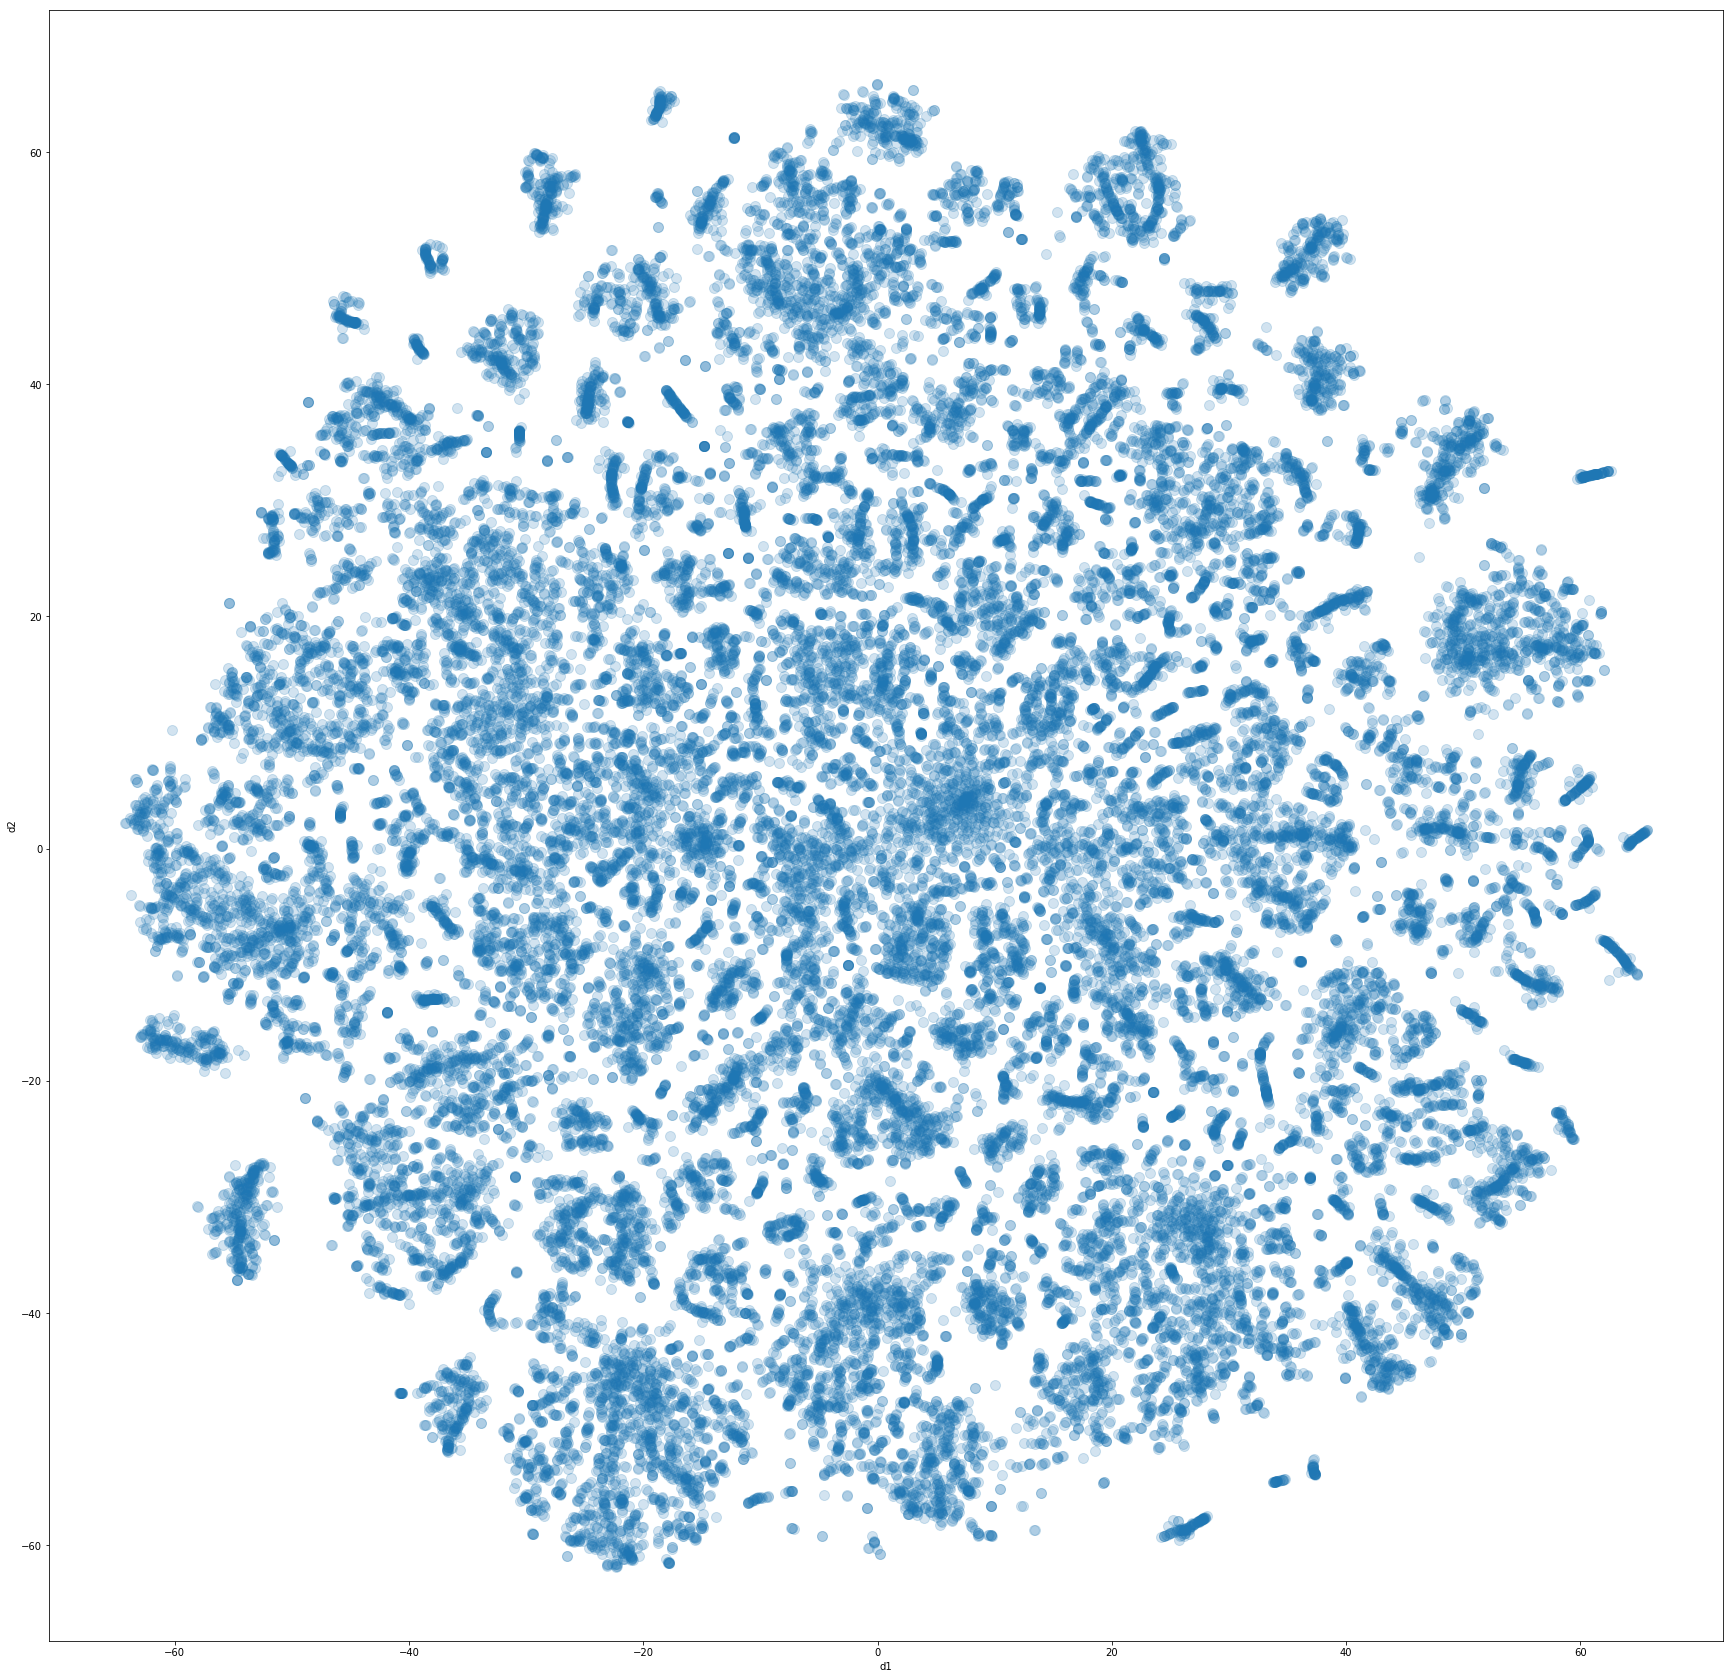

In [37]:
df_tsne.plot(kind='scatter', x='d1', y='d2', alpha=0.2, figsize=(30, 30), s=100)

In [ ]:
30 * np.exp(-0.01 * np.arange(10))

In [ ]:
#10 * np.log(1./(np.arange(100) + 1.))

In [ ]:
2. * (0.5 - np.random.random(1))

In [48]:
def plot_word_tsne(df_emb, df_emb_backgrnd, plot_text=True):
    # 2000./(np.arange(len(df_emb)) + 1.)
    _, ax = plt.subplots()
    df_emb.plot(ax=ax, kind='scatter', x='d1', y='d2', 
        alpha=0.5, figsize=(30, 30), s=500 * np.exp(-0.01 * np.arange(len(df_emb))), c='red')
    if plot_text:
        font_sizes = 60 * np.exp(-0.01 * np.arange(len(df_emb)))
        j = 0
        texts = []
        for d1, d2, voc in df_emb[['d1', 'd2', 'vocab']].values:
            #delta_1, delta_2 = 3 * (0.5 - np.random.random(1)), 3 * (0.5 - np.random.random(1))
            texts.append(plt.text(d1, d2, voc, fontsize=16, alpha=1., color='blue'))
            j += 1
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='r', lw=1.0))
    df_emb_backgrnd.plot(ax=ax, kind='scatter', x='d1', y='d2', 
        alpha=0.1, figsize=(30, 30), s=100, c='lightgray')

In [ ]:
plot_word_tsne(df_tsne300)

In [ ]:
plot_word_tsne(df_tsne300, plot_text=False)

In [ ]:
plot_word_tsne(df_pca300)

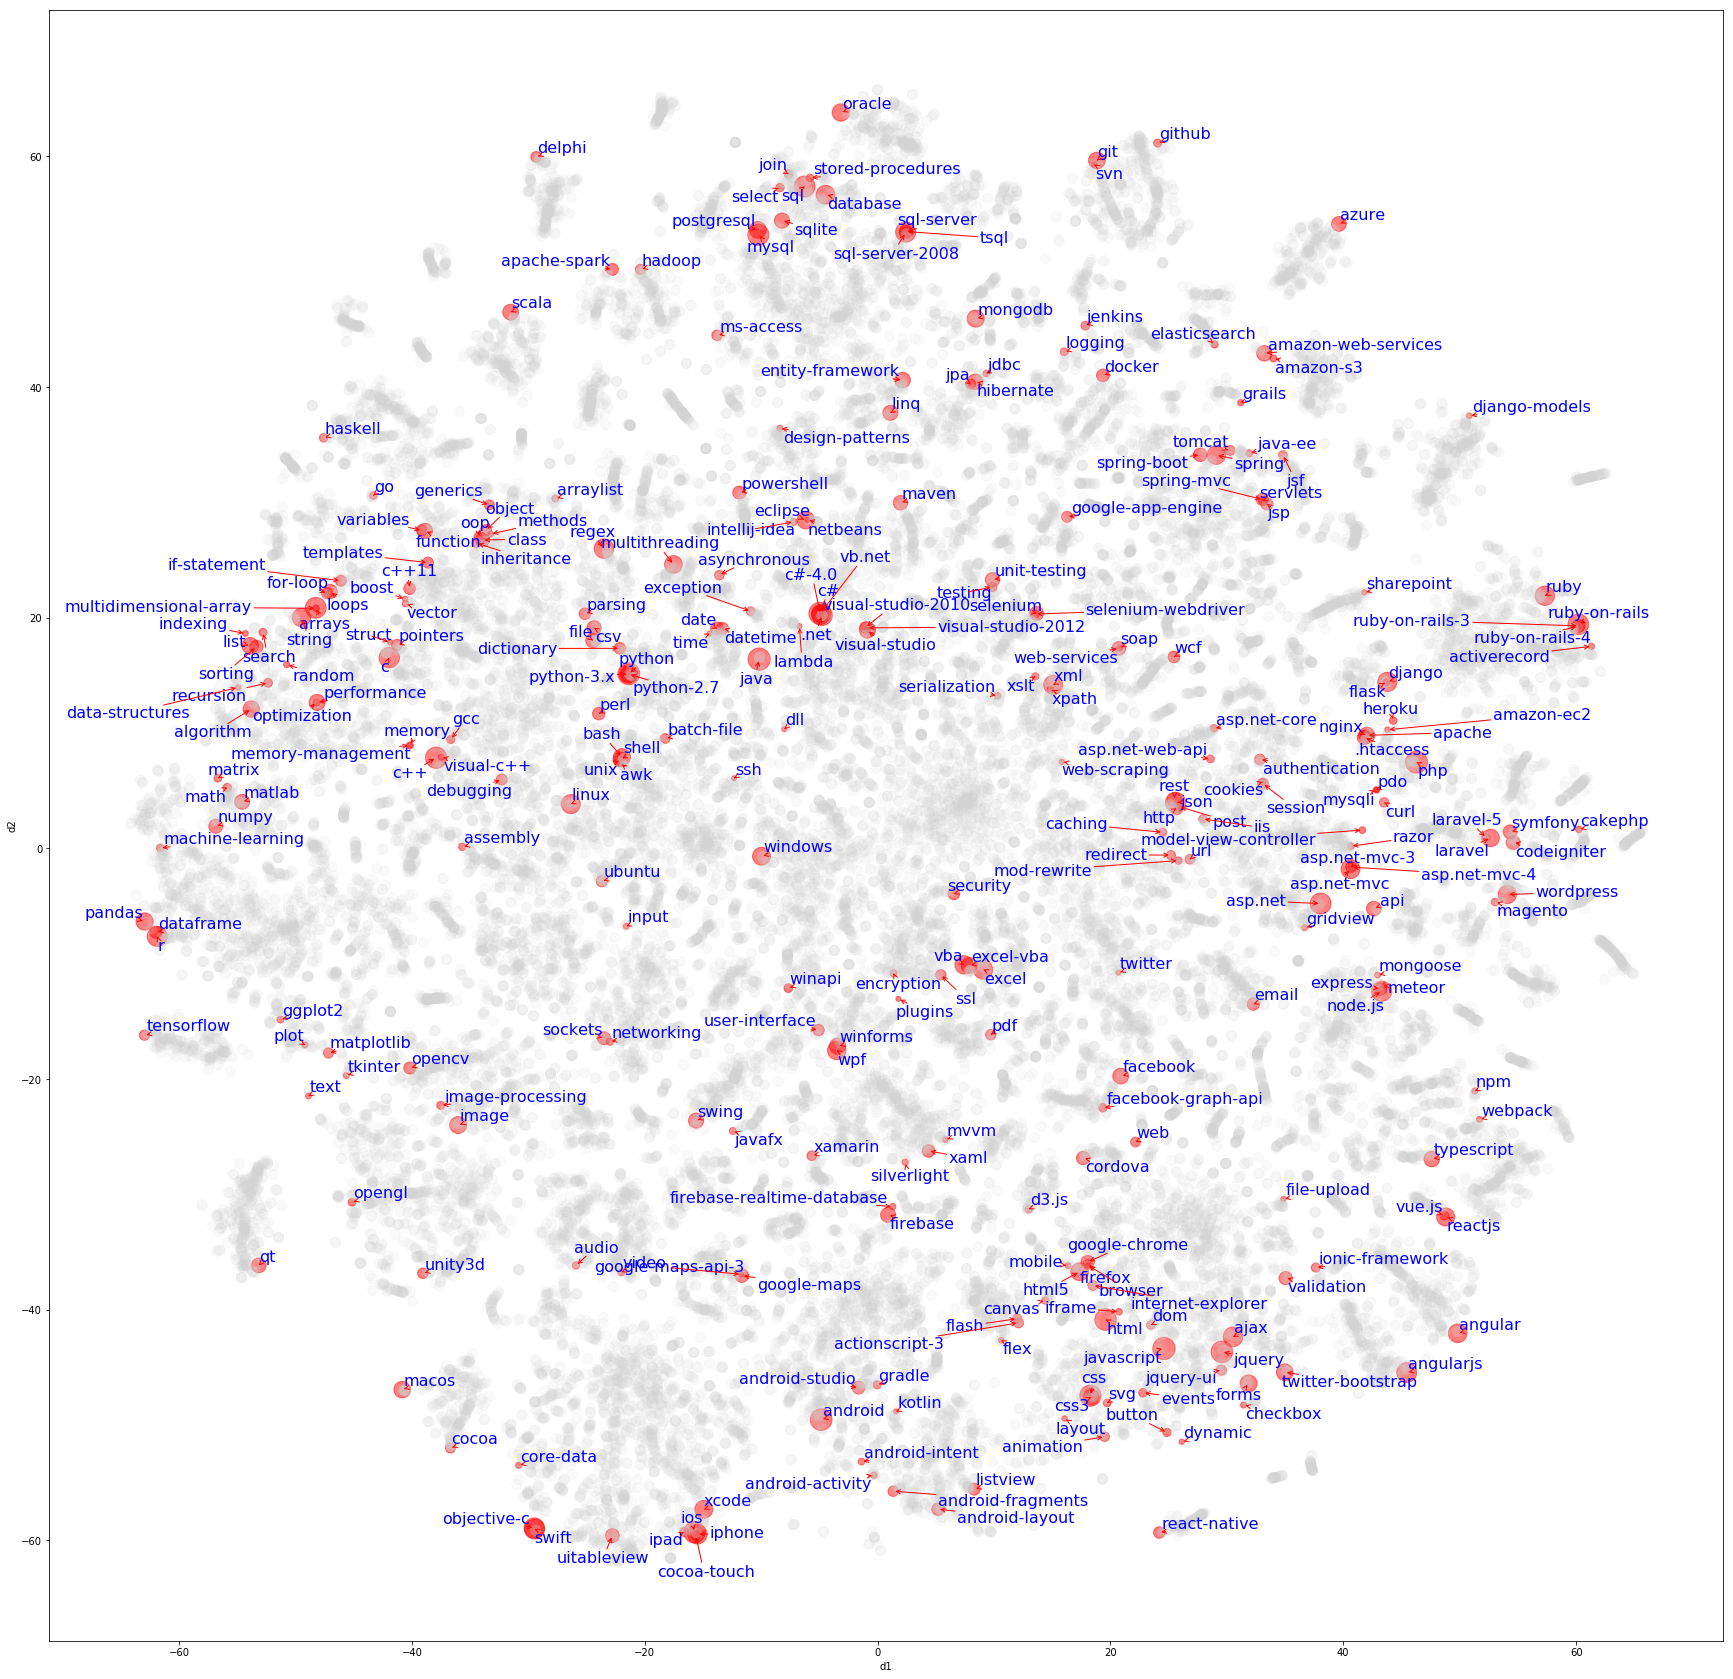

In [49]:
plot_word_tsne(df_tsne.iloc[:300], df_tsne.iloc[300:], plot_text=True)

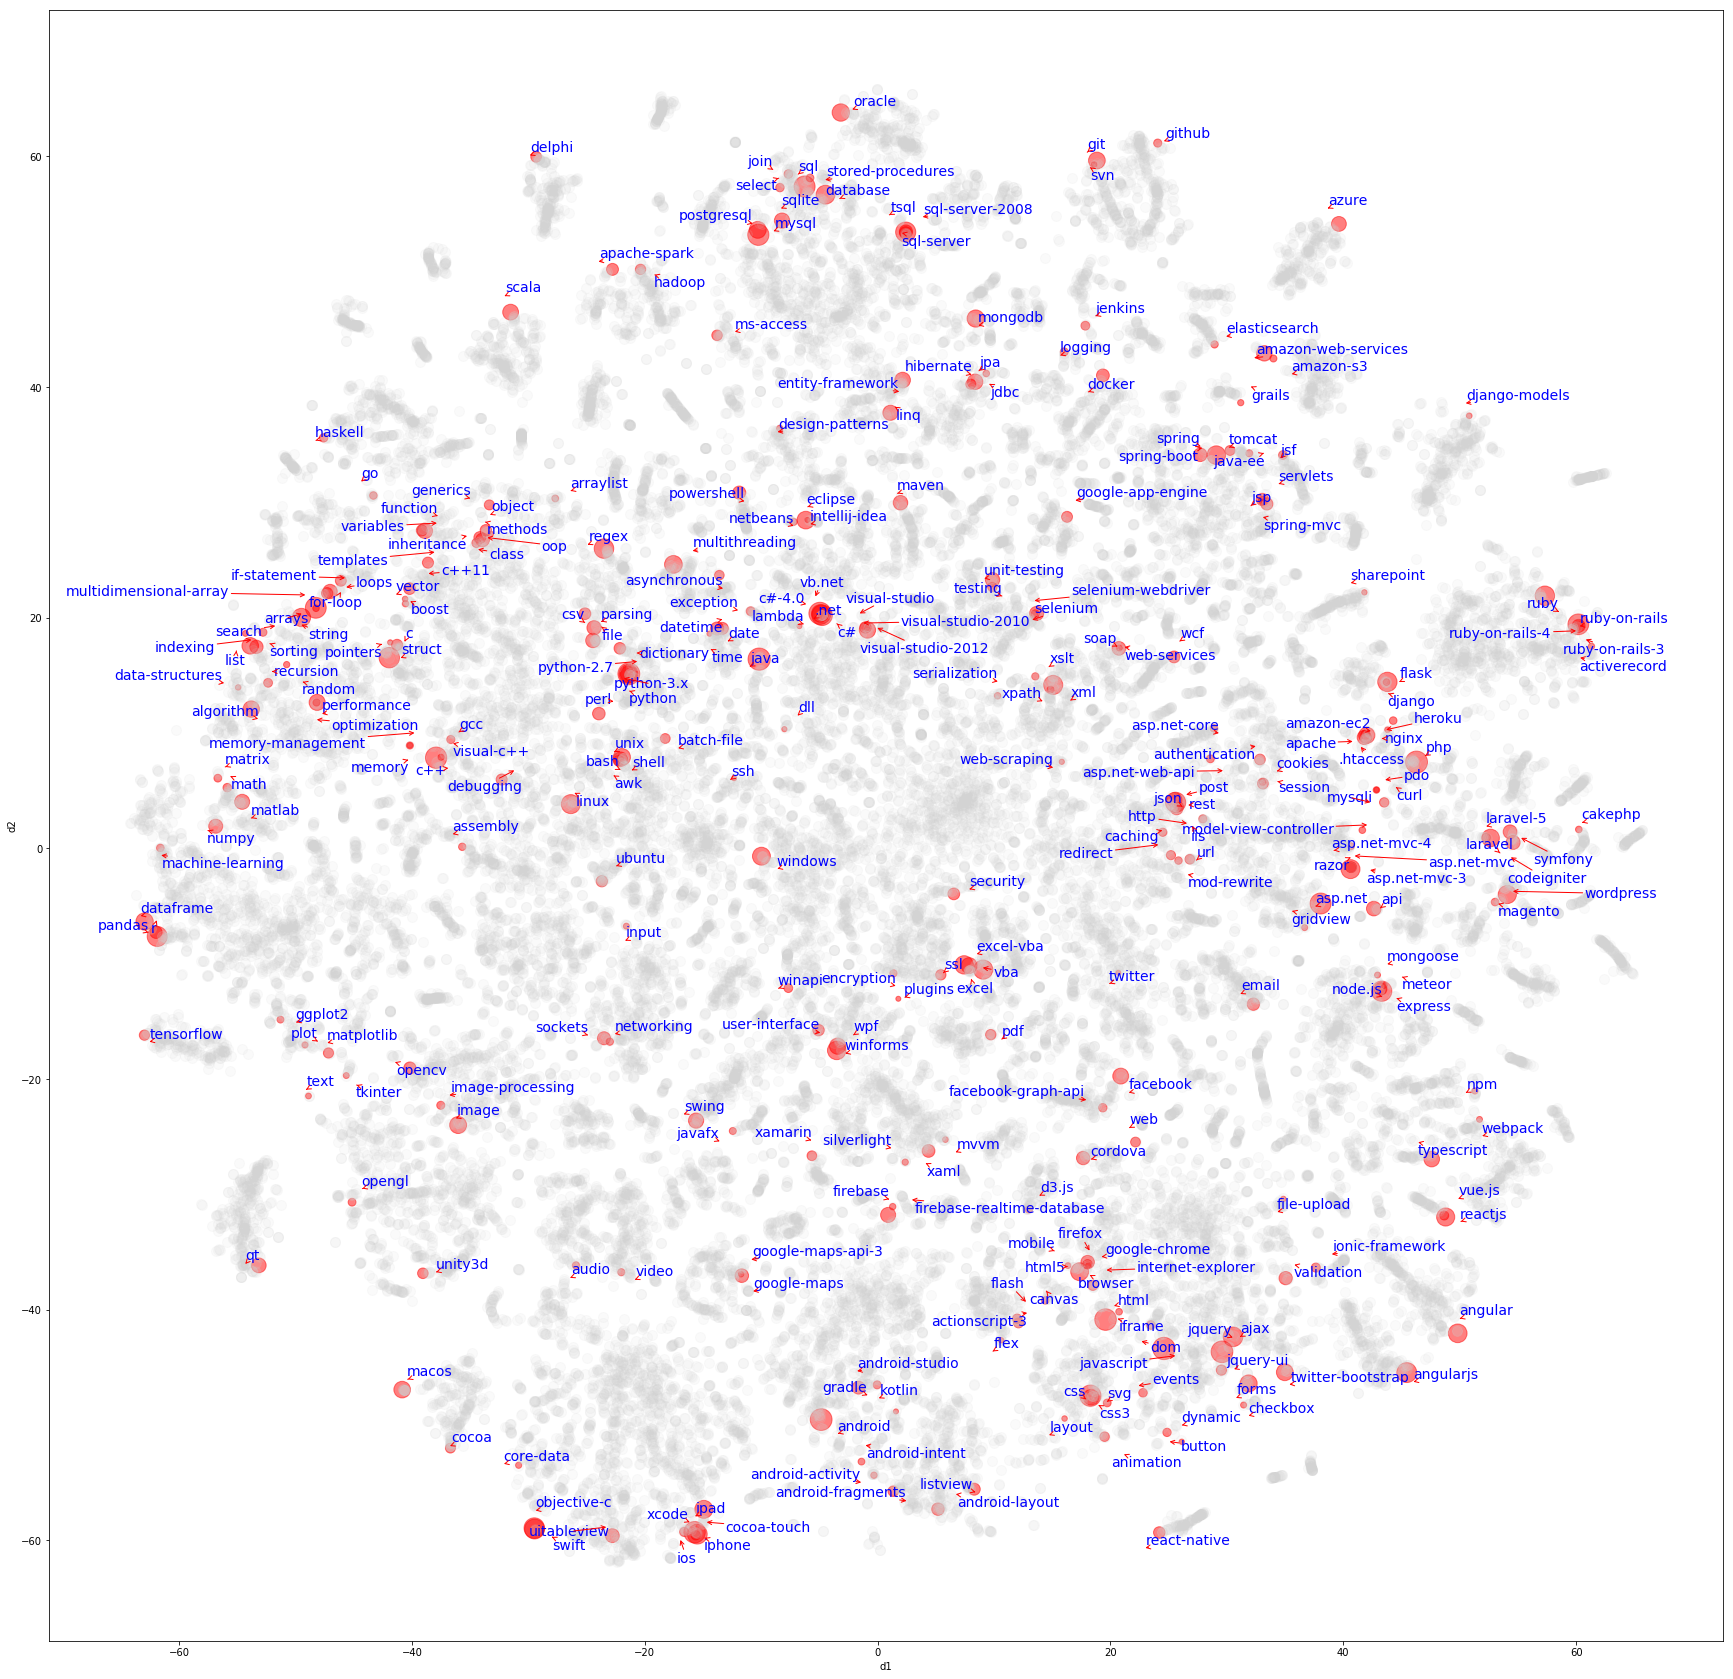

In [47]:
plot_word_tsne(df_tsne.iloc[:300], df_tsne.iloc[300:], plot_text=True)

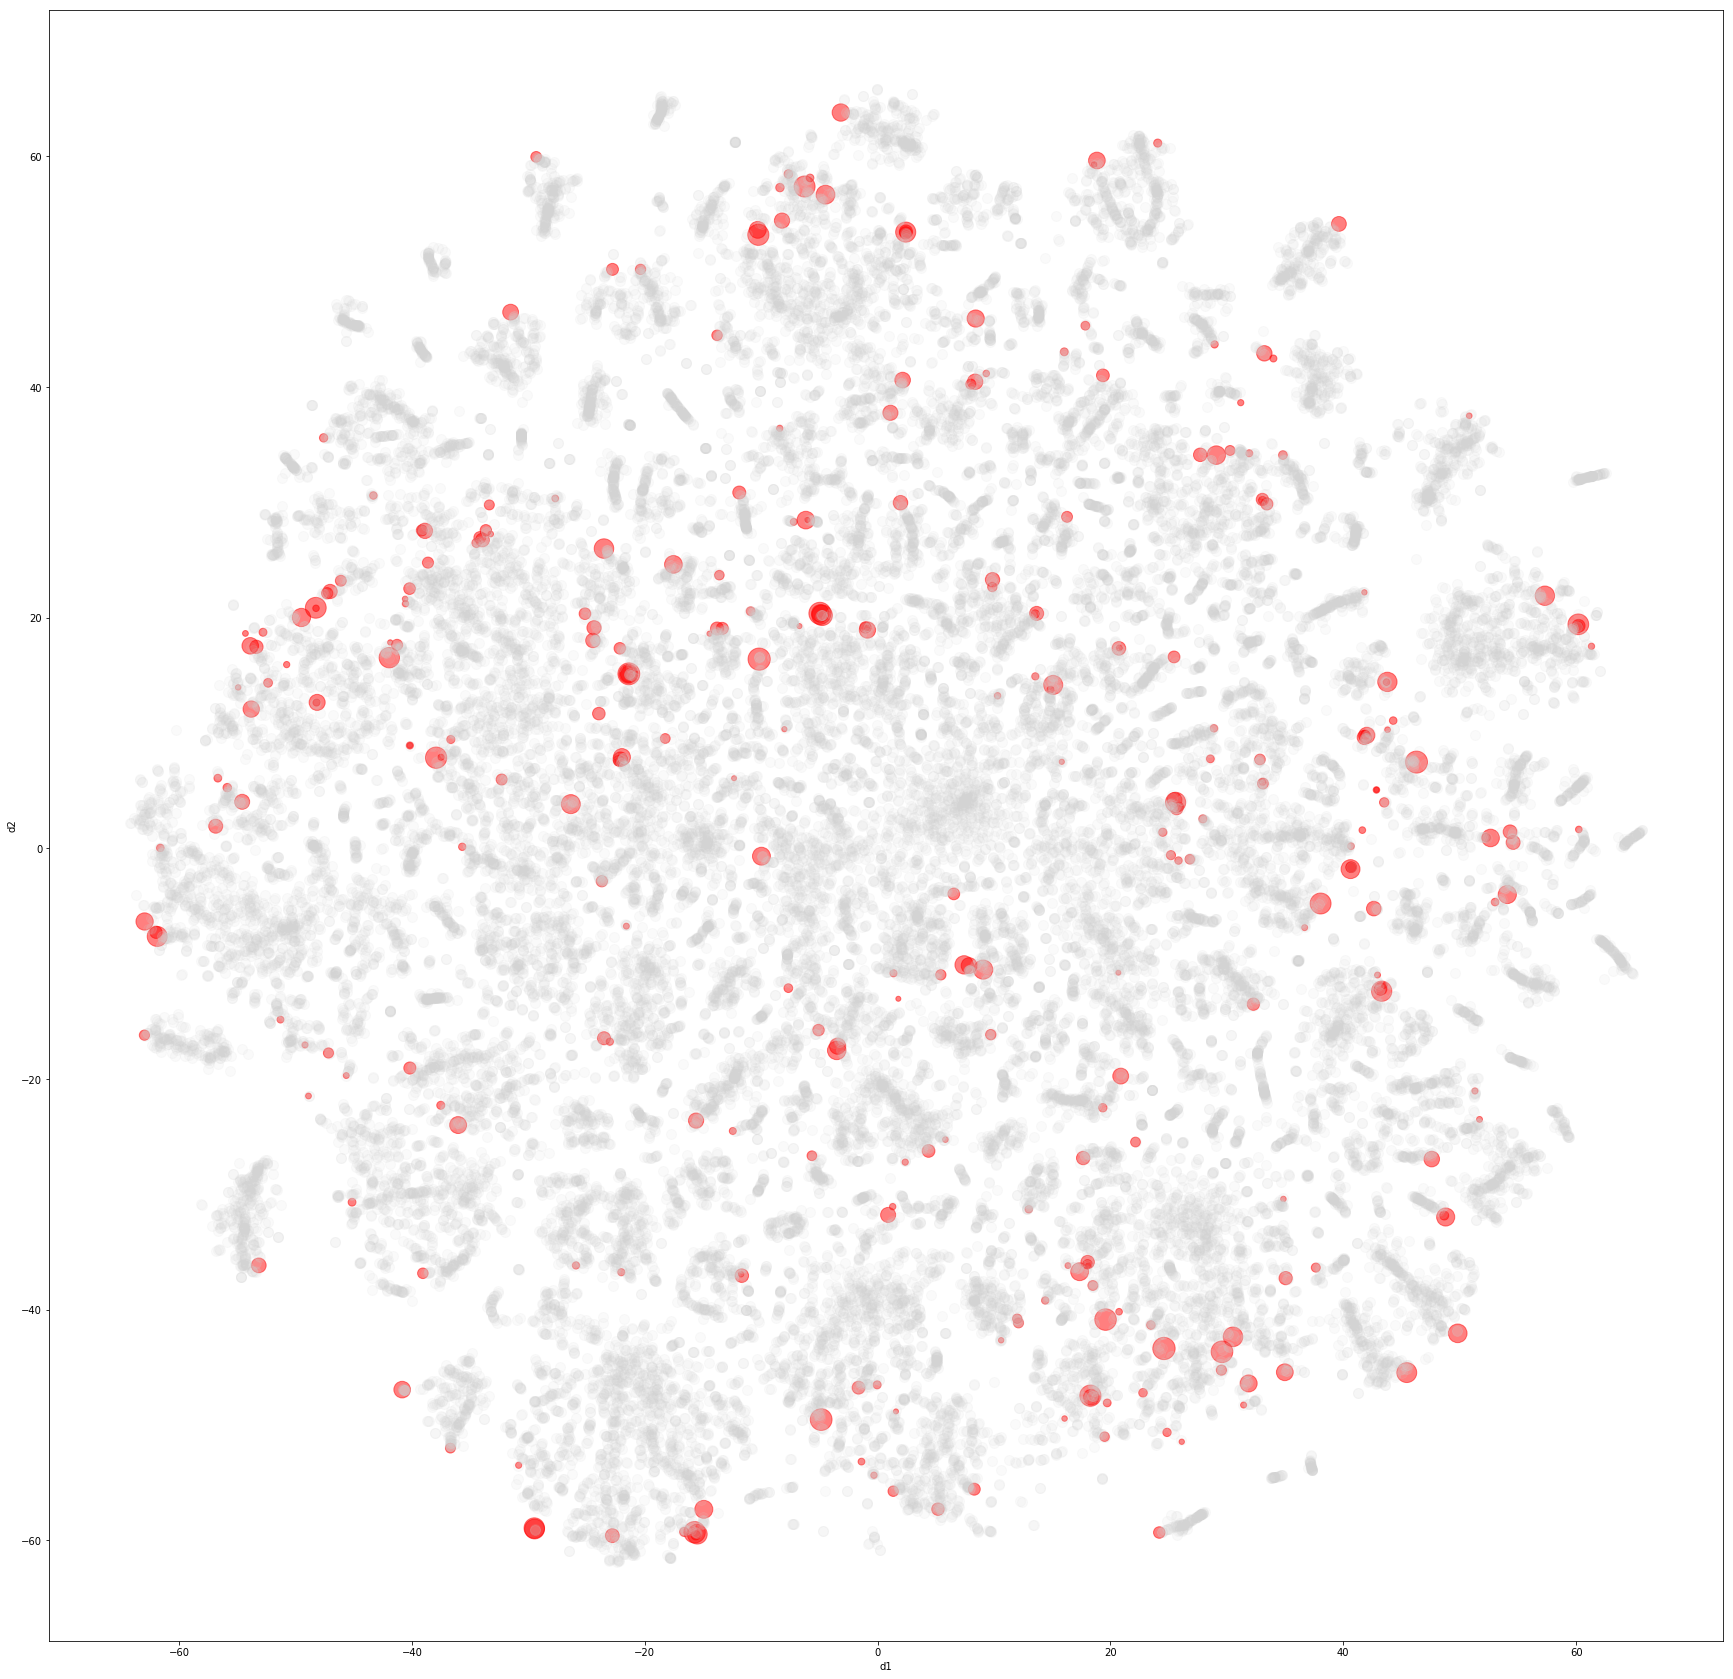

In [38]:
plot_word_tsne(df_tsne.iloc[:300], df_tsne.iloc[300:], plot_text=False)


In [ ]:
plot_word_tsne(df_tsne.iloc[300:600])

In [ ]:
df_tsne.iloc[:250].plot(kind='scatter', x='d1', y='d2', 
                        alpha=0.2, figsize=(20, 10), s=1000./(np.arange(100) + 1.), c='red')
for d1, d2, voc in df_tsne[['d1', 'd2', 'vocab']].values[:250]:
    plt.text(d1, d2, voc, fontsize=10, alpha=0.5)

In [ ]:
plot_word_tsne(df_ts)

In [ ]:
model.wv.most_similar(['spring-kafka'])

In [ ]:
np.random.seed(43)
ix = np.random.choice(np.arange(len(df_tsne)), size=300, replace=False)

In [ ]:
df_tsne.iloc[ix].plot(kind='scatter', x='d1', y='d2', 
                        alpha=0.2, figsize=(20, 10), s=100, c='red')
for d1, d2, voc in df_tsne[['d1', 'd2', 'vocab']].values[ix]:
    plt.text(d1, d2, voc, fontsize=10, alpha=0.5)

In [ ]:
pd.DataFrame(X_emb, columns=['d1', 'd2']).to_csv('tSNE_embed_vectors_word2vec_tag_model_Jun13.csv')

In [ ]:
create_download_link('tSNE_embed_vectors_word2vec_tag_model_Jun13.csv')

In [ ]:
model.wv.vocab['google-maps']

In [ ]:
model.wv.index2word[4]

In [ ]:
model.wv.index2entity

In [ ]:
(model.wv['mysql'] == model.wv.vectors[11]).all()